In [1]:
# In this project I'll try to explore the results of sentiment analysis with supervisioned machine learning technique

In [23]:
# preparing the environment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [3]:
# loading the csv dataset
df = pd.read_csv("reviews_data.csv")

In [4]:
# first check on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [5]:
# I won't use column "Image_links", so I am dropping it
df.drop(columns="Image_Links")

,name,location,Date,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...
...,...,...,...,...,...
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...
846,Bob,"Goodrich, MI","Reviewed Jan. 3, 2005",NaN,No Review Text
847,Erik,"Valley Village, CA","Reviewed Nov. 5, 2004",NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL..."
848,Andrew,"Fallbrook, CA","Reviewed Oct. 20, 2004",NaN,No Review Text


In [6]:
df.isna().sum()

name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

In [7]:
# "Rating" column has null data, in fact, 145 null data. Let's solve this issue, before applying the ML functions
# I don't have any information about this null data, how it was collected, and its full context. Therefore, I don't think I can replace it with median values, or use any other approach. In this case, I will take the approach of discarding this null data and starting the machine learning training without these 145 data rows.
df_filtered = df[df["Rating"].isnull() != True]

In [8]:
df_filtered

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...
...,...,...,...,...,...,...
700,Margaret,"Cotati, CA","Reviewed Oct. 2, 2011",1.0,I ordered Via Starbucks coffee online. I recei...,['No Images']
701,Ric,"Oakville, ON","Reviewed Aug. 31, 2011",3.0,"My name is Ric **, I am journalist by professi...",['No Images']
702,Jayne,"Ny, NY","Reviewed Aug. 24, 2011",1.0,"The bagel was ice cold, not cut and not toasted.",['No Images']
703,Norma,"La Puente, CA","Reviewed Aug. 15, 2011",1.0,"In the morning of Monday, August 15, 2011, at ...",['No Images']


In [9]:
df_filtered.isna().sum()

name           0
location       0
Date           0
Rating         0
Review         0
Image_Links    0
dtype: int64

In [10]:
df_filtered = df_filtered.drop(columns="Image_Links")

In [11]:
# I have remembered that this Dataset has some "No Review Text" information. I will drop those columns too
df_noreview = df_filtered[df_filtered["Review"] == "No Review Text"]

In [12]:
df_noreview.value_counts()

name    location      Date                    Rating  Review        
Donald  Orlando, FL   Reviewed Nov. 22, 2021  1.0     No Review Text    1
Sharon  Culpeper, VA  Reviewed July 18, 2022  2.0     No Review Text    1
Name: count, dtype: int64

In [13]:
df_filtered = df_filtered[df_filtered["Review"] != "No Review Text"]

In [14]:
df_filtered

,name,location,Date,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...
...,...,...,...,...,...
700,Margaret,"Cotati, CA","Reviewed Oct. 2, 2011",1.0,I ordered Via Starbucks coffee online. I recei...
701,Ric,"Oakville, ON","Reviewed Aug. 31, 2011",3.0,"My name is Ric **, I am journalist by professi..."
702,Jayne,"Ny, NY","Reviewed Aug. 24, 2011",1.0,"The bagel was ice cold, not cut and not toasted."
703,Norma,"La Puente, CA","Reviewed Aug. 15, 2011",1.0,"In the morning of Monday, August 15, 2011, at ..."


In [17]:
# Ok, I've removed the NaN values. Now I need to normalize the "text review" data to apply supervised training.

def clean_review(text):
    if pd.isnull(text):
        return ''
    text = text.lower()  # lower case
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'[^a-záéíóúâêîôûãõç\s]', '', text)  # remove simbols, ponctuation and emojis
    text = re.sub(r'\s+', ' ', text)  # removes a lot of whitespace
    return text.strip()

# Applying to "Review" column
df_filtered['cleaned_reviews'] = df_filtered['Review'].apply(clean_review)

# Let's see the first rows
print(df_filtered[['Review', 'cleaned_reviews']].head())

                                              Review  \
0  Amber and LaDonna at the Starbucks on Southwes...   
1  ** at the Starbucks by the fire station on 436...   
2  I just wanted to go out of my way to recognize...   
3  Me and my friend were at Starbucks and my card...   
4  I’m on this kick of drinking 5 cups of warm wa...   

                                     cleaned_reviews  
0  amber and ladonna at the starbucks on southwes...  
1  at the starbucks by the fire station on in alt...  
2  i just wanted to go out of my way to recognize...  
3  me and my friend were at starbucks and my card...  
4  im on this kick of drinking cups of warm water...  


In [ ]:
df_filtered 

,name,location,Date,Rating,Review,cleaned_reviews
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,amber and ladonna at the starbucks on southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,at the starbucks by the fire station on in alt...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,i just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,me and my friend were at starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,im on this kick of drinking cups of warm water...
...,...,...,...,...,...,...
700,Margaret,"Cotati, CA","Reviewed Oct. 2, 2011",1.0,I ordered Via Starbucks coffee online. I recei...,i ordered via starbucks coffee online i receiv...
701,Ric,"Oakville, ON","Reviewed Aug. 31, 2011",3.0,"My name is Ric **, I am journalist by professi...",my name is ric i am journalist by profession i...
702,Jayne,"Ny, NY","Reviewed Aug. 24, 2011",1.0,"The bagel was ice cold, not cut and not toasted.",the bagel was ice cold not cut and not toasted
703,Norma,"La Puente, CA","Reviewed Aug. 15, 2011",1.0,"In the morning of Monday, August 15, 2011, at ...",in the morning of monday august at am my cowor...


In [18]:
# Text processing complete! Now I want to separate "Rating" greater than 3 as positive from less than 3 as negative, and equal to 3 as neutral.
def sentiment_classifier(rating):
    if rating > 3:
        return 'positive'
    elif rating < 3:
        return 'negative'
    else:
        return 'neutral'




In [21]:
#Applying the function
df_filtered['sentiment_label'] = df_filtered["Rating"].apply(sentiment_classifier)

In [22]:
df_filtered

,name,location,Date,Rating,Review,cleaned_reviews,sentiment_label
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,amber and ladonna at the starbucks on southwes...,positive
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,at the starbucks by the fire station on in alt...,positive
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,i just wanted to go out of my way to recognize...,positive
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,me and my friend were at starbucks and my card...,positive
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,im on this kick of drinking cups of warm water...,positive
...,...,...,...,...,...,...,...
700,Margaret,"Cotati, CA","Reviewed Oct. 2, 2011",1.0,I ordered Via Starbucks coffee online. I recei...,i ordered via starbucks coffee online i receiv...,negative
701,Ric,"Oakville, ON","Reviewed Aug. 31, 2011",3.0,"My name is Ric **, I am journalist by professi...",my name is ric i am journalist by profession i...,neutral
702,Jayne,"Ny, NY","Reviewed Aug. 24, 2011",1.0,"The bagel was ice cold, not cut and not toasted.",the bagel was ice cold not cut and not toasted,negative
703,Norma,"La Puente, CA","Reviewed Aug. 15, 2011",1.0,"In the morning of Monday, August 15, 2011, at ...",in the morning of monday august at am my cowor...,negative


In [29]:
print(df_filtered['sentiment_label'].value_counts())


sentiment_label
negative    548
positive    122
neutral      33
Name: count, dtype: int64


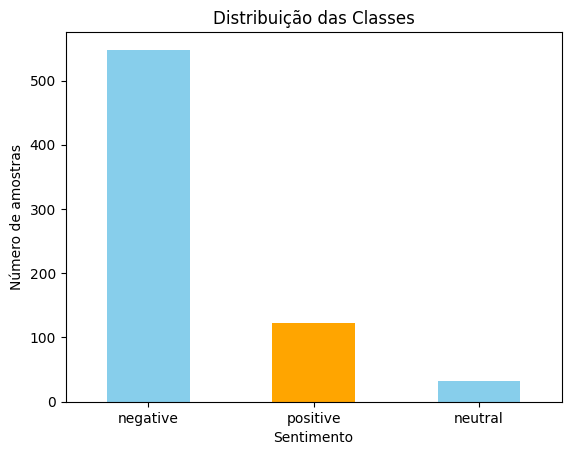

In [41]:
import matplotlib.pyplot as plt

# Contagem das classes no dataset original
class_counts = y.value_counts()

# Plotar distribuição
class_counts.plot(kind='bar', title='Distribuição das Classes', color=['skyblue', 'orange'])
plt.xlabel('Sentimento')
plt.ylabel('Número de amostras')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# the dataset is unbalanced, now I need to study how should I balance the dataset before applying any supervised model
